## Preprocesamiento de datos, tp3


lo de abajo es lo mismo que lo de arriba pero ma corto porque esta solo con la de 2025

In [2]:
# ============================
# TP4 - PREPARACIÓN DE LA BASE
# SOLO AÑO 2025
# ============================

# Install pyreadstat if not already installed
from google.colab import drive
drive.mount('/content/drive')
!pip install pyreadstat
import pandas as pd
import numpy as np
import pyreadstat
from pathlib import Path
from sklearn.model_selection import train_test_split

# ---- Rutas ----
archivos = Path("/content/drive/Shareddrives/Casinos/Ciencia de datos tp")
individual2025_archivos = archivos/"usu_individual_T125.xlsx"
hogar2025_archivos      = archivos/"usu_hogar_T125.xlsx"
tabla_equiv_archivos    = archivos/"tabla_adulto_equiv (1).xlsx"

# ---- Carga base individual 2025 ----
data_2025 = pd.read_excel(individual2025_archivos)

# ---- Filtrar región 42 ----
data_2025 = data_2025[data_2025["REGION"] == 42].copy()

# ---- Limpieza de códigos negativos ----
codigos_na = [-1, -7, -8, -9]
for col in data_2025.select_dtypes(include=["Int64", "float64", "int64"]).columns:
    data_2025[col] = data_2025[col].replace(codigos_na, np.nan)

# ---- Tabla adulto equivalente ----
tabla_equiv = pd.read_excel(tabla_equiv_archivos)
tabla_equiv.columns = ["EDAD", "MUJERES", "VARONES"]

def asignar_adulto_equiv(row):
    edad = row["CH06"]
    sexo = row["CH04"]  # 1 hombre, 2 mujer

    if pd.isna(edad) or pd.isna(sexo):
        return np.nan

    if sexo == 1:
        return tabla_equiv.loc[tabla_equiv["EDAD"] == edad, "VARONES"].values[0]
    elif sexo == 2:
        return tabla_equiv.loc[tabla_equiv["EDAD"] == edad, "MUJERES"].values[0]
    else:
        return np.nan

data_2025["adulto_equiv"] = data_2025.apply(asignar_adulto_equiv, axis=1)

# ---- Adulto equivalente por hogar ----
data_2025["ad_equiv_hogar"] = data_2025.groupby(["CODUSU","NRO_HOGAR"])["adulto_equiv"].transform("sum")

# ---- Línea de pobreza 2025 ----
data_2025["ingreso_necesario"] = 365_177 * data_2025["ad_equiv_hogar"]

# ---- Variable POBRE ----
data_2025["POBRE"] = (
    (data_2025["ITF"].notna()) &
    (data_2025["ITF"] != 0) &
    (data_2025["ingreso_necesario"] > data_2025["ITF"])
).astype(int)

# ---- Crear EDAD y EDAD2 ----
data_2025 = data_2025.rename(columns={"CH06": "EDAD"})
data_2025["EDAD2"] = data_2025["EDAD"] ** 2

# ---- Años de educación ----
def calcular_educ(row):
    nivel = row["CH12"]
    fin   = row["CH13"]
    ult   = row["CH14"]

    if pd.isna(nivel):
        return np.nan

    if nivel in [1, 2]:  # primario
        return 6 if (nivel == 2 or fin == 1) else ult
    if nivel in [3, 4]:  # secundario
        return 12 if (nivel == 4 or fin == 1) else 6 + (ult or 0)
    if nivel in [5, 6]:  # terciario
        return 15 if (nivel == 6 or fin == 1) else 12 + (ult or 0)
    if nivel in [7, 8]:  # universitario
        return 17 if (nivel == 8 or fin == 1) else 12 + (ult or 0)
    if nivel == 9:       # posgrado
        return 17 + (ult or 2)

data_2025["EDUC"] = data_2025.apply(calcular_educ, axis=1)

# ---- Horas trabajadas ----
data_2025["horastrab"] = data_2025["PP3E_TOT"].fillna(0) + data_2025["PP3F_TOT"].fillna(0)

# ---- Merge con hogar 2025 para IX_TOT ----
hogar_2025 = pd.read_excel(hogar2025_archivos)
hogar_2025 = hogar_2025[["CODUSU", "IX_TOT"]]

data_2025 = data_2025.merge(hogar_2025, on="CODUSU", how="left")

# ---- Dummies ----
data_2025["MUJER"] = (data_2025["CH04"] == 2).astype(int)
data_2025["PAREJA"] = data_2025["CH07"].isin([1, 2]).astype(int)

s = data_2025["CH08"].replace({9: np.nan})
data_2025["OBRA_SOCIAL"]  = s.isin([1, 12, 13, 123]).astype(int)
data_2025["PREPAGA"]      = s.isin([2, 12, 23, 123]).astype(int)
data_2025["PLAN_PUBLICO"] = s.isin([3, 13, 23, 123]).astype(int)
data_2025["SIN_COBERTURA"] = (s == 4).fillna(False).astype(int)

# ---- Estado ocupacional ----
data_2025["OCUPADO"]    = (data_2025["ESTADO"] == 1).astype(int)
data_2025["DESOCUPADO"] = (data_2025["ESTADO"] == 2).astype(int)
data_2025["INACTIVO"]   = (data_2025["ESTADO"] == 3).astype(int)

# ---- Categoría ocupacional ----
data_2025["PATRON"]         = (data_2025["CAT_OCUP"] == 1).astype(int)
data_2025["CUENTA_PROPIA"]  = (data_2025["CAT_OCUP"] == 2).astype(int)
data_2025["OBRERO"]         = (data_2025["CAT_OCUP"] == 3).astype(int)
data_2025["FAMILIAR_SNREM"] = (data_2025["CAT_OCUP"] == 4).astype(int)

data_2025["ESTUDIANTE"] = (data_2025["CAT_INAC"] == 3).astype(int)
data_2025["AMA_CASA"]   = (data_2025["CAT_INAC"] == 4).astype(int)
data_2025["JUBILADO"]   = (data_2025["CAT_INAC"] == 1).astype(int)

data_2025["ALGUNA_COBERTURA"] = (
    (data_2025["OBRA_SOCIAL"] == 1) |
    (data_2025["PREPAGA"] == 1) |
    (data_2025["PLAN_PUBLICO"] == 1)
).astype(int)

# ---- Features que vas a usar ----
#features_base = [
#    "EDAD", "EDAD2", "IX_TOT",
#    "ad_equiv_hogar", "adulto_equiv",
#    "EDUC", "MUJER", "PAREJA",
#    "OBRA_SOCIAL", "PREPAGA", "PLAN_PUBLICO", "SIN_COBERTURA",
 #   "horastrab",
  #  "OCUPADO", "DESOCUPADO", "INACTIVO",
   # "PATRON", "CUENTA_PROPIA", "OBRERO", "FAMILIAR_SNREM",
    #"ESTUDIANTE", "AMA_CASA", "JUBILADO",
    #"ALGUNA_COBERTURA"]


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.9 MB/s eta 0:00:00


/tmp/ipython-input-3887226933.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_2025["adulto_equiv"] = data_2025.apply(asignar_adulto_equiv, axis=1)
/tmp/ipython-input-3887226933.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_2025["ad_equiv_hogar"] = data_2025.groupby(["CODUSU","NRO_HOGAR"])["adulto_equiv"].transform("sum")
/tmp/ipython-input-3887226933.py:57: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [3]:
features_base = [
    "IX_TOT",
    "adulto_equiv", "MUJER", "EDUC",

    "PREPAGA", "SIN_COBERTURA",
    "horastrab",
    "JUBILADO",
]

# ---- Armado de matrices X e y ----
df_model = data_2025[["POBRE"] + features_base].dropna()

X = df_model[features_base]
y = df_model["POBRE"].astype(int)

X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X, y, test_size=0.30, random_state=444, stratify=y
)


## TP4

Modelo de regresión logística con Regularización: Ridge y LASSO

In [4]:
# === TP4 — Modelos con regularización y árboles (usando solo 2025) ===
# Este bloque asume que ya existen: X_train_25, X_test_25, y_train_25, y_test_25

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    classification_report,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

# ---------------------------------------------------------------------
# Helper: usar X_train_25 / X_test_25 sin la columna 'const'
# ---------------------------------------------------------------------
cols_features = [c for c in X_train_25.columns if c.lower() != "const"]
Xtr = X_train_25[cols_features].copy()
Xte = X_test_25[cols_features].copy()
ytr = y_train_25.copy()
yte = y_test_25.copy()

# Solo numéricas por seguridad
Xtr = Xtr.select_dtypes(include=[np.number])
Xte = Xte[Xtr.columns]

feature_names = list(Xtr.columns)



In [5]:
import pandas as pd
import numpy as np

features_base = [
    "IX_TOT",
    "adulto_equiv",
    "PREPAGA",
    "SIN_COBERTURA",
    "horastrab",
    "JUBILADO",
]

dummies = ["MUJER", "PREPAGA", "SIN_COBERTURA", "JUBILADO"]
continuas = ["IX_TOT", "adulto_equiv", "EDUC", "horastrab"]

print("\n==============================")
print("  CHEQUEO DE VARIABLES")
print("==============================\n")

# --------------------------------
# 1. Verificar existencia de columnas
# --------------------------------
print("1) Chequeo de existencia de columnas\n")

for col in features_base:
    if col in df_model.columns:
        print(f"✔ {col}: OK")
    else:
        print(f"✘ {col}: NO EXISTE EN EL DATAFRAME")

# --------------------------------
# 2. Forzar a numérico (coerce)
# --------------------------------
for col in features_base:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors="coerce")

# --------------------------------
# 3. Chequeo de missing generados
# --------------------------------
print("\n2) Cantidad de NaN luego de coerce\n")

for col in features_base:
    if col in df_model.columns:
        n_nan = df_model[col].isna().sum()
        print(f"{col}: {n_nan} NaN")

# --------------------------------
# 4. Estadísticos de continuas
# --------------------------------
print("\n3) Estadísticos de variables continuas (media y desvío)\n")

for col in continuas:
    if col in df_model.columns:
        media = df_model[col].mean()
        sd = df_model[col].std()
        print(f"{col}: media = {media:.4f} | sd = {sd:.4f}")

# --------------------------------
# 5. Conteo de dummies (0 y 1)
# --------------------------------
print("\n4) Recuento de variables dummies (0 y 1)\n")

for col in dummies:
    if col in df_model.columns:
        conteo = df_model[col].value_counts().sort_index()
        print(f"\n{col}:")
        for k, v in conteo.items():
            print(f"  valor {int(k)} → {int(v)} observaciones")

print("\n==============================")
print("  FIN DEL CHEQUEO")
print("==============================")



  CHEQUEO DE VARIABLES

1) Chequeo de existencia de columnas

✔ IX_TOT: OK
✔ adulto_equiv: OK
✔ PREPAGA: OK
✔ SIN_COBERTURA: OK
✔ horastrab: OK
✔ JUBILADO: OK

2) Cantidad de NaN luego de coerce

IX_TOT: 0 NaN
adulto_equiv: 0 NaN
PREPAGA: 0 NaN
SIN_COBERTURA: 0 NaN
horastrab: 0 NaN
JUBILADO: 0 NaN

3) Estadísticos de variables continuas (media y desvío)

IX_TOT: media = 3.9397 | sd = 1.8946
adulto_equiv: media = 0.8216 | sd = 0.1378
EDUC: media = 11.7926 | sd = 10.5542
horastrab: media = 16.3131 | sd = 21.8490

4) Recuento de variables dummies (0 y 1)


MUJER:
  valor 0 → 2168 observaciones
  valor 1 → 2389 observaciones

PREPAGA:
  valor 0 → 4456 observaciones
  valor 1 → 101 observaciones

SIN_COBERTURA:
  valor 0 → 2866 observaciones
  valor 1 → 1691 observaciones

JUBILADO:
  valor 0 → 4111 observaciones
  valor 1 → 446 observaciones

  FIN DEL CHEQUEO


#**Parte A**

#A.1

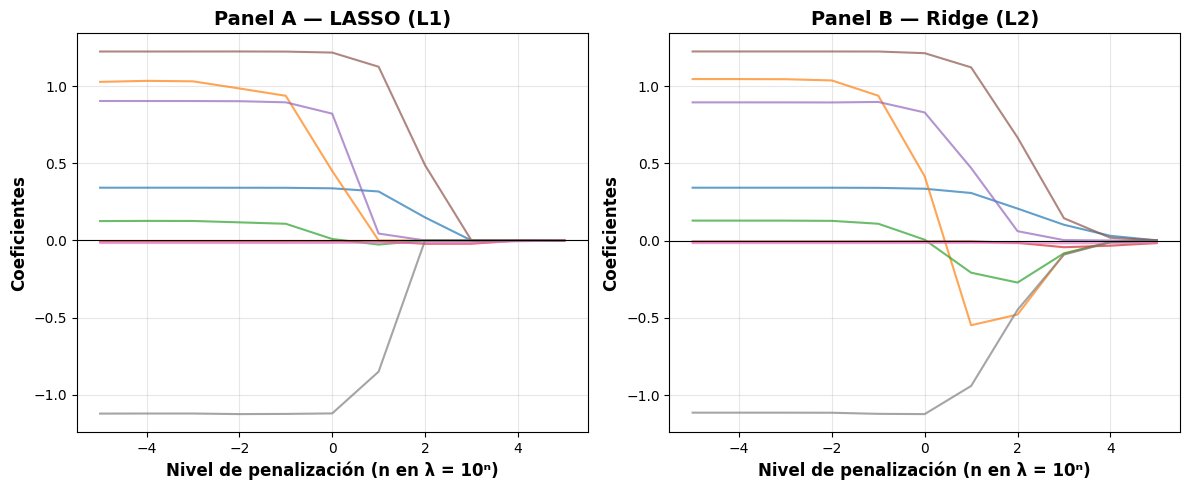

In [6]:
# ---------------------------------------------------------------------
# Parte A.1 — Trayectorias de coeficientes para LASSO (L1) y Ridge (L2)
# ---------------------------------------------------------------------

# lambda = 10^n, n = -5,...,5
n_grid = np.arange(-5, 6)
lambdas = 10.0 ** n_grid
Cs = 1.0 / lambdas  # C es la inversa de la fuerza de penalización

coefs_l1 = []
coefs_l2 = []

for C in Cs:
    # LASSO (L1)
    logit_l1 = LogisticRegression(
        penalty="l1",
        C=C,
        solver="liblinear",
        max_iter=2000,
    )
    logit_l1.fit(Xtr, ytr)
    coefs_l1.append(logit_l1.coef_[0])

    # Ridge (L2)
    logit_l2 = LogisticRegression(
        penalty="l2",
        C=C,
        solver="liblinear",
        max_iter=2000,
    )
    logit_l2.fit(Xtr, ytr)
    coefs_l2.append(logit_l2.coef_[0])

coefs_l1 = np.vstack(coefs_l1)  # shape (n_lambda, n_features)
coefs_l2 = np.vstack(coefs_l2)

# Gráficos de trayectorias de coeficientes
plt.figure(figsize=(12, 5))


# Panel LASSO
plt.subplot(1, 2, 1)
for j in range(coefs_l1.shape[1]):
    plt.plot(n_grid, coefs_l1[:, j], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Panel A — LASSO (L1)", fontsize = 14, weight = "bold")
plt.xlabel("Nivel de penalización (n en λ = 10ⁿ)", fontsize = 12, weight = "bold")
plt.ylabel("Coeficientes", fontsize = 12, weight = "bold")
plt.grid(alpha=0.3)

# Panel Ridge
plt.subplot(1, 2, 2)
for j in range(coefs_l2.shape[1]):
    plt.plot(n_grid, coefs_l2[:, j], alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Panel B — Ridge (L2)", fontsize = 14, weight = "bold")
plt.xlabel("Nivel de penalización (n en λ = 10ⁿ)", fontsize = 12, weight = "bold")
plt.ylabel("Coeficientes", fontsize = 12, weight = "bold")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#A.2

=== Penalidad óptima (según CV, en términos de λ) ===
LASSO (L1): λ* ≈ 1.00000  (C* = 1.00000)
Ridge (L2): λ* ≈ 10.00000  (C* = 0.10000)


/tmp/ipython-input-211645462.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors_l1[:, i] for i in range(len(Cs))], labels=labels_lambda, showfliers=False)
/tmp/ipython-input-211645462.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([errors_l2[:, i] for i in range(len(Cs))], labels=labels_lambda, showfliers=False)


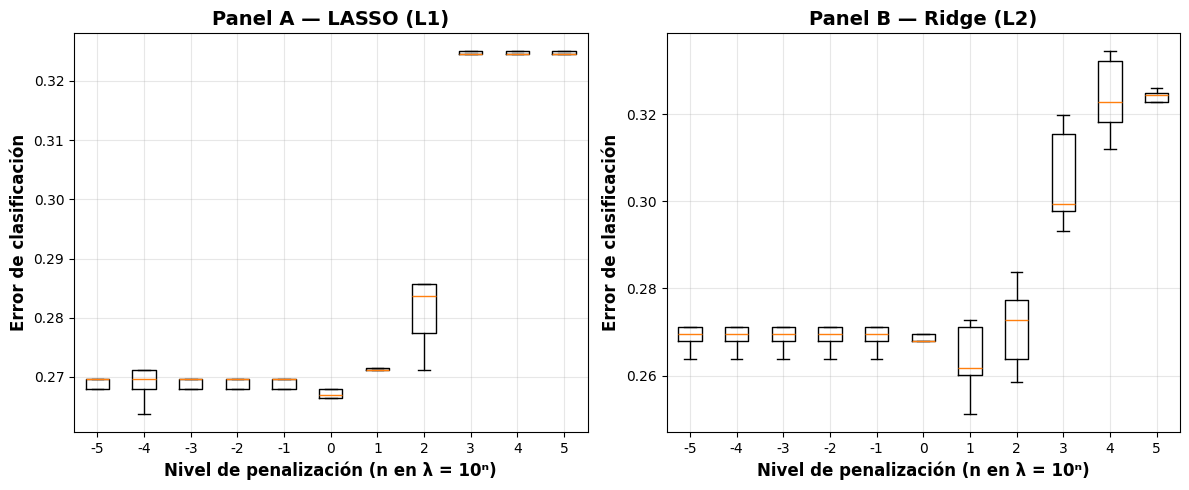

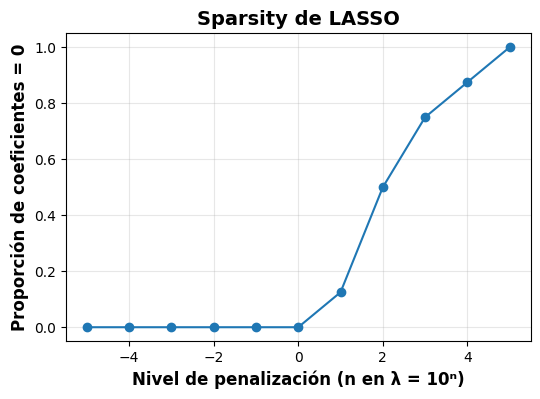

In [7]:

# ---------------------------------------------------------------------
# Parte A.2 — LogisticRegressionCV para elegir λ óptimo (L1 y L2)
# ---------------------------------------------------------------------

logitcv_l1 = LogisticRegressionCV(
    Cs=list(Cs),
    cv=5,
    penalty="l1",
    solver="liblinear",
    scoring="accuracy",
    max_iter=3000,
    refit=True,
)
logitcv_l1.fit(Xtr, ytr)

logitcv_l2 = LogisticRegressionCV(
    Cs=list(Cs),
    cv=5,
    penalty="l2",
    solver="liblinear",
    scoring="accuracy",
    max_iter=3000,
    refit=True,
)
logitcv_l2.fit(Xtr, ytr)

best_C_l1 = float(logitcv_l1.C_[0])
best_C_l2 = float(logitcv_l2.C_[0])

best_lambda_l1 = 1.0 / best_C_l1
best_lambda_l2 = 1.0 / best_C_l2

print("=== Penalidad óptima (según CV, en términos de λ) ===")
print(f"LASSO (L1): λ* ≈ {best_lambda_l1:.5f}  (C* = {best_C_l1:.5f})")
print(f"Ridge (L2): λ* ≈ {best_lambda_l2:.5f}  (C* = {best_C_l2:.5f})")

# Boxplots del error de clasificación por λ
scores_l1 = logitcv_l1.scores_[1] if 1 in logitcv_l1.scores_ else list(logitcv_l1.scores_.values())[0]
scores_l2 = logitcv_l2.scores_[1] if 1 in logitcv_l2.scores_ else list(logitcv_l2.scores_.values())[0]

# scores_: shape (n_folds, n_Cs) o (n_Cs, n_folds) según versión → homogeneizamos
if scores_l1.shape[0] == len(Cs):
    scores_l1 = scores_l1.T
if scores_l2.shape[0] == len(Cs):
    scores_l2 = scores_l2.T

errors_l1 = 1.0 - scores_l1  # matriz (n_folds, n_Cs)
errors_l2 = 1.0 - scores_l2

#labels_lambda = [f"1e{n}" for n in n_grid]
labels_lambda = [str(n) for n in n_grid]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([errors_l1[:, i] for i in range(len(Cs))], labels=labels_lambda, showfliers=False)
plt.xlabel("Nivel de penalización (n en λ = 10ⁿ)", fontsize=12, weight="bold")
plt.ylabel("Error de clasificación", fontsize = 12, weight = "bold")
plt.title("Panel A — LASSO (L1)", fontsize = 14, weight = "bold")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([errors_l2[:, i] for i in range(len(Cs))], labels=labels_lambda, showfliers=False)
plt.xlabel("Nivel de penalización (n en λ = 10ⁿ)", fontsize=12, weight="bold")
plt.ylabel("Error de clasificación", fontsize = 12, weight = "bold")
plt.title("Panel B — Ridge (L2)", fontsize = 14, weight = "bold")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# (Opcional) Proporción de coeficientes en cero para LASSO
prop_zero_l1 = (coefs_l1 == 0).mean(axis=1)
plt.figure(figsize=(6,4))
plt.plot(n_grid, prop_zero_l1, marker="o")
plt.xlabel("Nivel de penalización (n en λ = 10ⁿ)", fontsize = 12, weight = "bold")
plt.ylabel("Proporción de coeficientes = 0", fontsize = 12, weight = "bold")
plt.title("Sparsity de LASSO", fontsize = 14, weight = "bold")
plt.grid(alpha=0.3)
plt.show()

In [8]:
best_lambda_l1 = 1.0 / best_C_l1
best_lambda_l2 = 1.0 / best_C_l2
print(f"LASSO (L1): λ* ≈ {best_lambda_l1:.5f}")
print(f"Ridge (L2): λ* ≈ {best_lambda_l2:.5f}")


LASSO (L1): λ* ≈ 1.00000
Ridge (L2): λ* ≈ 10.00000


#A.3

In [9]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# Logit "clásico" con statsmodels usando LAS MISMAS Xtr, ytr del TP4
# ---------------------------------------------------------------------

# 1) Armar X a partir de Xtr con nombres de columnas
#    (si Xtr ya es DataFrame, lo copiamos; si es array, lo envolvemos)

try:
    # Si Xtr ya es DataFrame
    X_sm = Xtr.copy()
except AttributeError:
    # Si Xtr es un array de NumPy
    X_sm = pd.DataFrame(Xtr, columns=feature_names)

# y: usamos directamente ytr (las mismas etiquetas que en sklearn)
y_sm = pd.Series(ytr, name="POBRE")

# 2) Limpiar NaN e infinitos para que statsmodels no explote
X_sm = X_sm.replace([np.inf, -np.inf], np.nan)

mask = X_sm.notnull().all(axis=1) & pd.notnull(y_sm)
X_clean = X_sm.loc[mask]
y_clean = y_sm.loc[mask]

# 3) Agregar constante para el intercepto
X_clean_const = sm.add_constant(X_clean, has_constant="add")

# 4) Estimar Logit clásico
logit_sm = sm.Logit(y_clean, X_clean_const).fit()

# 5) Ver summary
print(logit_sm.summary())

# 5) Calcular AUC sobre las mismas observaciones usadas en el ajuste
y_pred_prob = logit_sm.predict(X_clean_const)   # Probabilidad predicha de ser "1"
auc_sm = roc_auc_score(y_clean, y_pred_prob)

print(f"\nAUC (statsmodels, sobre este conjunto): {auc_sm:.3f}")

Optimization terminated successfully.
         Current function value: 0.517046
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  POBRE   No. Observations:                 3189
Model:                          Logit   Df Residuals:                     3180
Method:                           MLE   Df Model:                            8
Date:                Wed, 26 Nov 2025   Pseudo R-squ.:                  0.1799
Time:                        20:36:12   Log-Likelihood:                -1648.9
converged:                       True   LL-Null:                       -2010.6
Covariance Type:            nonrobust   LLR p-value:                6.209e-151
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.2418      0.452     -7.172      0.000      -4.128      -2.356
IX_TOT            0.

In [10]:
# Asegurate antes de TODO que Xtr no tenga 'const'
# (si tu X_train_25 tenía const, hacé algo así cuando lo creás:)
# Xtr = X_train_25.drop(columns=["const"])
# Xte = X_test_25.drop(columns=["const"])

# ---------------------------------------------------------------------
# Parte A.3 — Logit sin penalidad vs L1 vs L2 con λ* elegido
# ---------------------------------------------------------------------

# Nombres de variables EXACTOS que usa el modelo
feature_names = list(Xtr.columns)   # esto garantiza que matchee con coef_

# Sin penalización
logit_none = LogisticRegression(
    penalty=None,
    solver="lbfgs",
    max_iter=10_000,
)
logit_none.fit(Xtr, ytr)

# Con penalidad óptima L1 y L2
logit_l1_best = LogisticRegression(
    penalty="l1",
    C=best_C_l1,
    solver="liblinear",
    max_iter=3000,
)
logit_l1_best.fit(Xtr, ytr)

logit_l2_best = LogisticRegression(
    penalty="l2",
    C=best_C_l2,
    solver="liblinear",
    max_iter=3000,
)
logit_l2_best.fit(Xtr, ytr)

coef_none = logit_none.coef_[0]      # largo = n_features
coef_l1b  = logit_l1_best.coef_[0]
coef_l2b  = logit_l2_best.coef_[0]

# Armar vector (intercepto + coeficientes) → largo = 1 + n_features
beta_none_full = np.r_[logit_none.intercept_[0], coef_none]
beta_l1_full   = np.r_[logit_l1_best.intercept_[0], coef_l1b]
beta_l2_full   = np.r_[logit_l2_best.intercept_[0], coef_l2b]

# Índice: "intercepto" + nombres de variables → largo = 1 + n_features
index_coefs = ["intercepto"] + feature_names

coef_table = pd.DataFrame(
    {
        "beta_sin_pen": beta_none_full,
        "beta_L1":      beta_l1_full,
        "beta_L2":      beta_l2_full,
    },
    index=index_coefs
)

print("\n=== Tabla de coeficientes: sin penalidad vs LASSO vs Ridge ===")
print(coef_table)



=== Tabla de coeficientes: sin penalidad vs LASSO vs Ridge ===
               beta_sin_pen   beta_L1   beta_L2
intercepto        -3.241651 -2.790621 -1.555131
IX_TOT             0.341887  0.338852  0.307715
adulto_equiv       1.050047  0.565690 -0.548378
MUJER              0.129778  0.032191 -0.208255
EDUC              -0.005623 -0.004870 -0.005077
PREPAGA            0.902655  0.823260  0.469294
SIN_COBERTURA      1.224012  1.217552  1.120832
horastrab         -0.016749 -0.015976 -0.014759
JUBILADO          -1.119270 -1.109650 -0.941287


#**Parte B**

#B.4


=== Árbol CART: mejor ccp_alpha según CV: 0.001762 ===


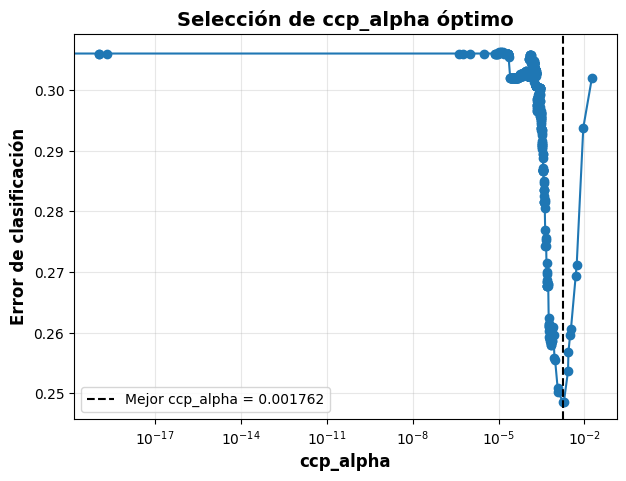

In [11]:
# ---------------------------------------------------------------------
# Parte B.4 — Árbol CART con poda por costo de complejidad (ccp_alpha)
# ---------------------------------------------------------------------

# Árbol inicial para obtener la grilla de ccp_alpha
tree_base = DecisionTreeClassifier(
    random_state=123,
)
path = tree_base.cost_complexity_pruning_path(Xtr, ytr)
ccp_alphas = path.ccp_alphas

# Quitamos el último alpha (árbol con un solo nodo)
ccp_alphas = ccp_alphas[:-1]

mean_errors = []

for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(
        random_state=123,
        ccp_alpha=alpha,
    )
    scores = cross_val_score(tree, Xtr, ytr, cv=10, scoring="accuracy")
    mean_errors.append(1.0 - scores.mean())

best_idx = int(np.argmin(mean_errors))
best_alpha = float(ccp_alphas[best_idx])

print(f"\n=== Árbol CART: mejor ccp_alpha según CV: {best_alpha:.6f} ===")

plt.figure(figsize=(7,5))
plt.plot(ccp_alphas, mean_errors, marker="o")
plt.axvline(x=best_alpha, color="black", linestyle="--", label=f"Mejor ccp_alpha = {best_alpha:.6f}")
plt.xscale("log")
plt.xlabel("ccp_alpha", fontsize = 12, weight = "bold")
plt.ylabel("Error de clasificación", fontsize = 12, weight = "bold")
plt.title("Selección de ccp_alpha óptimo", fontsize = 14, weight = "bold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#B.5

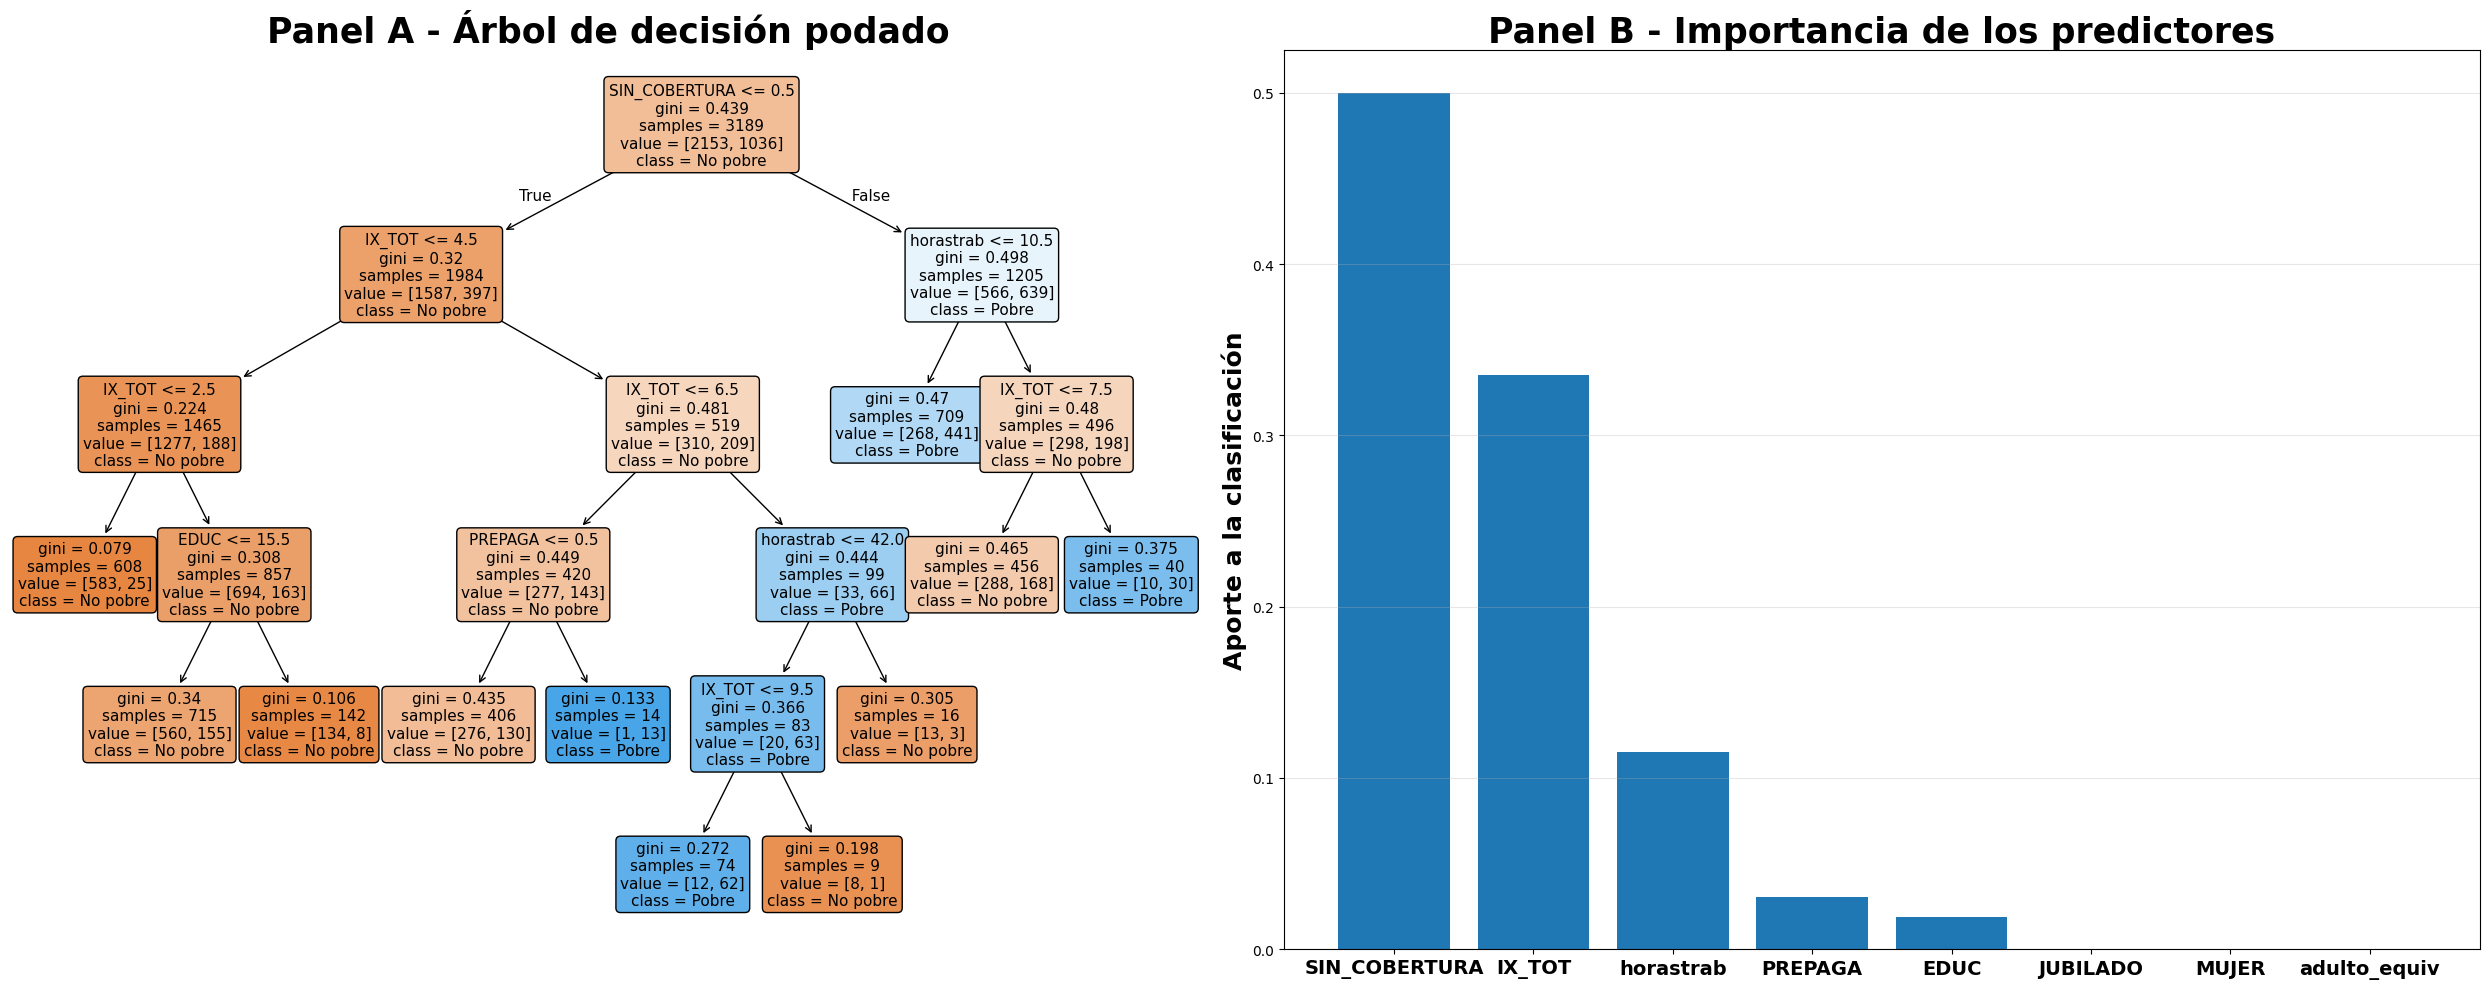

In [12]:
# ---------------------------------------------------------------------
# Parte B.5 — Árbol final podado + importancia de variables (LEGIBLE)
# ---------------------------------------------------------------------

tree_best = DecisionTreeClassifier(
    random_state=123,
    ccp_alpha=best_alpha,
)
tree_best.fit(Xtr, ytr)

plt.figure(figsize=(25, 10))

# =======================
# Panel A — Árbol legible
# =======================
plt.subplot(1, 2, 1)
plot_tree(
    tree_best,
    feature_names=feature_names,
    class_names=["No pobre", "Pobre"],
    filled=True,
    #max_depth=3,     # <<< CAMBIO CLAVE: solo 3 niveles para que se vea
    fontsize=11,      # <<< texto más grande y claro
    rounded=True,
)
plt.title("Panel A - Árbol de decisión podado", fontsize= 25, weight = "bold", loc = "center")
plt.tight_layout()
#plt.show()

# ==============================
# Panel B — Importancia de vars
# ==============================
plt.subplot(1, 2, 2)
#plt.figure(figsize=(8, 5))

importances = tree_best.feature_importances_
idx_sorted = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[idx_sorted])
plt.xticks(range(len(importances)), np.array(feature_names)[idx_sorted], rotation=0, fontsize = 14, weight = "bold")
plt.grid(axis="y", alpha=0.3)

plt.title("Panel B - Importancia de los predictores", fontsize = 25, weight = "bold")
plt.ylabel("Aporte a la clasificación", fontsize=18, weight="bold")

plt.tight_layout()

plt.show()


#**Parte C**

#C.6

K óptimo (CV=5): 29


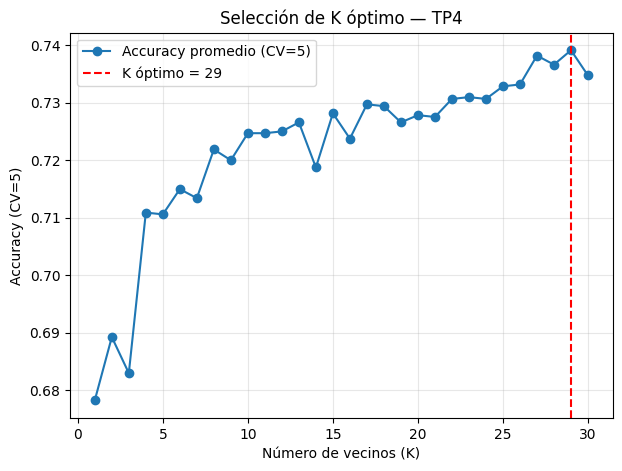


=== KNN (TP4, K óptimo por CV) ===
Accuracy en test: 0.735
AUC en test: 0.769


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------------------------
# 1) Armar Xtr numérico sin constante (TP4)
# ---------------------------------------------------------------------

# Si Xtr ya es DataFrame:
try:
    Xtr_knn = Xtr.copy()
    Xtr_knn.columns = feature_names
except:
    Xtr_knn = pd.DataFrame(Xtr, columns=feature_names)

# Nos quedamos solo con numéricas
Xtr_knn = Xtr_knn.select_dtypes(include=np.number)

# ---------------------------------------------------------------------
# 2) Búsqueda de K óptimo con CV=5
# ---------------------------------------------------------------------

k_values = range(1, 31)
acc_cv = []

for k in k_values:
    model = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k)
    )
    acc_cv.append(
        cross_val_score(
            model, Xtr_knn, ytr,
            cv=5,
            scoring="accuracy"
        ).mean()
    )

# K óptimo
k_opt = k_values[int(np.argmax(acc_cv))]
print("K óptimo (CV=5):", k_opt)

# ---------------------------------------------------------------------
# 3) Gráfico de selección de K
# ---------------------------------------------------------------------

plt.figure(figsize=(7,5))
plt.plot(list(k_values), acc_cv, marker='o', label="Accuracy promedio (CV=5)")
plt.axvline(x=k_opt, color='red', linestyle='--', label=f"K óptimo = {k_opt}")
plt.xlabel("Número de vecinos (K)")
plt.ylabel("Accuracy (CV=5)")
plt.title("Selección de K óptimo — TP4")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------------------------------------------------
# 4) Entrenar KNN final con K óptimo
# ---------------------------------------------------------------------

knn_kcv_tp4 = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=k_opt)
)

knn_kcv_tp4.fit(Xtr_knn, ytr)

# ---------------------------------------------------------------------
# 5) Evaluación en TEST
# ---------------------------------------------------------------------

# Armar Xte con las mismas columnas
try:
    Xte_knn = Xte.copy()
    Xte_knn.columns = feature_names
except:
    Xte_knn = pd.DataFrame(Xte, columns=feature_names)

Xte_knn = Xte_knn[Xtr_knn.columns]   # mismo orden de variables
Xte_knn = Xte_knn.select_dtypes(include=np.number)

# Predicción
yhat_test = knn_kcv_tp4.predict(Xte_knn)
yhat_prob = knn_kcv_tp4.predict_proba(Xte_knn)[:,1]

# Métricas
acc_knn = accuracy_score(yte, yhat_test)
auc_knn = roc_auc_score(yte, yhat_prob)

print("\n=== KNN (TP4, K óptimo por CV) ===")
print("Accuracy en test:", round(acc_knn, 3))
print("AUC en test:", round(auc_knn, 3))



=== Logit sin penalidad (scikit-learn) ===
Matriz de confusión (p > 0.5):
[[805 119]
 [250 194]]
Accuracy: 0.730  |  Sensibilidad (Pobres): 0.437  |  AUC: 0.776

=== Logit LASSO (L1) ===
Matriz de confusión (p > 0.5):
[[815 109]
 [260 184]]
Accuracy: 0.730  |  Sensibilidad (Pobres): 0.414  |  AUC: 0.777

=== Logit Ridge (L2) ===
Matriz de confusión (p > 0.5):
[[816 108]
 [261 183]]
Accuracy: 0.730  |  Sensibilidad (Pobres): 0.412  |  AUC: 0.777

=== Árbol CART podado ===
Matriz de confusión (p > 0.5):
[[784 140]
 [214 230]]
Accuracy: 0.741  |  Sensibilidad (Pobres): 0.518  |  AUC: 0.765

=== KNN con K-CV ===
Matriz de confusión (p > 0.5):
[[789 135]
 [228 216]]
Accuracy: 0.735  |  Sensibilidad (Pobres): 0.486  |  AUC: 0.769


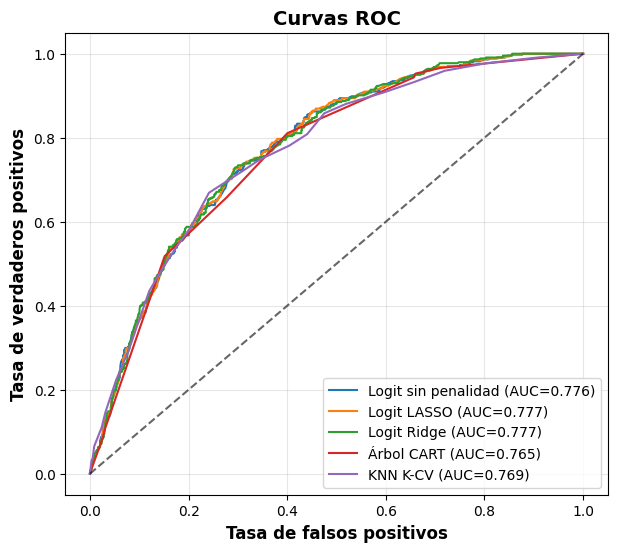


=== Resumen de métricas en TEST (2025) ===
                               modelo  accuracy  sensibilidad       auc   FN
0  Logit sin penalidad (scikit-learn)  0.730263      0.436937  0.775958  250
1                    Logit LASSO (L1)  0.730263      0.414414  0.776939  260
2                    Logit Ridge (L2)  0.730263      0.412162  0.776839  261
3                   Árbol CART podado  0.741228      0.518018  0.764707  214
4                        KNN con K-CV  0.734649      0.486486  0.769315  228


In [14]:
# ---------------------------------------------------------------------
# Parte C.6 — Comparación de desempeño en TEST (2025)
# ---------------------------------------------------------------------

def eval_model(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    TN, FP, FN, TP = cm.ravel()
    sensibilidad = TP / (TP + FN)

    print(f"\n=== {name} ===")
    print("Matriz de confusión (p > 0.5):")
    print(cm)
    print(f"Accuracy: {acc:.3f}  |  Sensibilidad (Pobres): {sensibilidad:.3f}  |  AUC: {auc:.3f}")

    return {
        "modelo": name,
        "accuracy": acc,
        "sensibilidad": sensibilidad,
        "auc": auc,
        "FN": FN   # opcional, pero muy útil para el Ministerio
    }
# Probabilidades en test (mismos Xte, yte que usaste antes)
y_prob_logit_none = logit_none.predict_proba(Xte)[:, 1]
y_prob_l1_best    = logit_l1_best.predict_proba(Xte)[:, 1]
y_prob_l2_best    = logit_l2_best.predict_proba(Xte)[:, 1]
y_prob_tree       = tree_best.predict_proba(Xte)[:, 1]

# <<< NUEVO: probabilidades del KNN entrenado en este TP (knn_kcv_tp4)
#     (Xte_knn es el que armaste antes con las mismas columnas que Xtr_knn)
y_prob_knn = knn_kcv_tp4.predict_proba(Xte_knn)[:, 1]

resultados = []
resultados.append(eval_model("Logit sin penalidad (scikit-learn)", yte, y_prob_logit_none))
resultados.append(eval_model("Logit LASSO (L1)", yte, y_prob_l1_best))
resultados.append(eval_model("Logit Ridge (L2)", yte, y_prob_l2_best))
resultados.append(eval_model("Árbol CART podado", yte, y_prob_tree))

# <<< ahora comparamos el KNN de este TP (no el del TP3)
if 'y_prob_knn' in locals():
    resultados.append(eval_model("KNN con K-CV", yte, y_prob_knn))

# Curvas ROC comparadas
plt.figure(figsize=(7,6))

for name, y_prob in [
    ("Logit sin penalidad", y_prob_logit_none),
    ("Logit LASSO", y_prob_l1_best),
    ("Logit Ridge", y_prob_l2_best),
    ("Árbol CART", y_prob_tree),
]:
    fpr, tpr, _ = roc_curve(yte, y_prob)
    auc_val = roc_auc_score(yte, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

# <<< agregamos la curva ROC del KNN si está definido
if 'y_prob_knn' in locals():
    fpr_knn, tpr_knn, _ = roc_curve(yte, y_prob_knn)
    auc_knn = roc_auc_score(yte, y_prob_knn)
    plt.plot(fpr_knn, tpr_knn, label=f"KNN K-CV (AUC={auc_knn:.3f})")

plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.xlabel("Tasa de falsos positivos", fontsize = 12, weight = "bold")
plt.ylabel("Tasa de verdaderos positivos", fontsize = 12, weight = "bold")
plt.title("Curvas ROC", fontsize = 14, weight = "bold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Tabla resumen de métricas
tabla_res = pd.DataFrame(resultados)
print("\n=== Resumen de métricas en TEST (2025) ===")
print(tabla_res)


#C.7

Si el objetivo es identificar hogares vulnerables para asignar recursos escasos de manera eficiente, el modelo más adecuado es el árbol de decisión podado. Este modelo combina:

Mejor desempeño predictivo (mayor accuracy y AUC)

Menor error 1 − accuracy

Reglas de decisión transparentes, fáciles de explicar y aplicar

Variables clave socialmente interpretables (obra social, tamaño equivalente del hogar, horas trabajadas)

Aunque LASSO ofrece un modelo parsimonioso y estable, su desempeño no supera al del árbol y es menos intuitivo para usuarios no técnicos. Por ello, el CART podado aparece como la mejor alternativa para una implementación real de política pública.